In [122]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import datetime

def obtener_tiempo(dfr):
    #Esta funcion permite obtener una columna Datetime a partir del agno, dia, hora y minuto de los datos iniciales
    dfr['Day'] = pd.to_datetime(dfr['Day'], format='%j').dt.strftime('%m-%d')
    dfr['Hour'] = dfr['Hour'].astype(str).str.zfill(2)
    dfr['Datetime'] = pd.to_datetime(dfr[['Year','Day', 'Hour', 'Minute']]
                   .astype(str).apply(' '.join, 1), format='%Y %m-%d %H %M') 
    return dfr

def sustituir(dfr):
    #Sustitucion de los valores 9999... por NaN (sabemos que la fila 2 son todo valores nulos para cada variable)
    valores_null = dfr.iloc[2, 4:]
    for i in range(len(valores_null)):
        dfr.iloc[:,i+4] = dfr.iloc[:,i+4].replace(valores_null[i], np.nan)
    return dfr

def imputar_por_interpolacion(dfr):
    #Sustituye los valores NaN por valores aproximados mediante el metodo de interpolacion
    dfr = dfr.interpolate(method='linear', limit_direction='forward')
    return dfr

def imputar_por_KNND(dfr):
    #Este metodo es para imputar las filas que no se hayan podido imputar con interpolacion (primera fila)
    imputer = KNNImputer(n_neighbors=3, weights = 'distance')
    dfr[:] = imputer.fit_transform(dfr)
    return dfr

def normalizar_datos(dfr):
    #Dado un DataFrame, devuelve el DataFrame con valores normalizados
    x = dfr.values #returns a numpy array
    standard_scaler = preprocessing.StandardScaler()
    dfr[:] = standard_scaler.fit_transform(x)
    #dfr = pd.DataFrame(x_scaled)
    return dfr

def desnormalizar_datos(dfr):
    #Dado un DataFrame, devuelve el DataFrame con valores desnormalizados
    x = dfr.values
    min_max_scaler = preprocessing.MinMaxScaler()
    dfr[:] = min_max_scaler.inverse_transform(x)
    return dfr

def eliminar_gaps(dfr, n):
    #Eliminacion de filas donde alguna columna tiene N NaNs consecutivos
    for columna in range(dfr.shape[1]):
        mask = dfr.iloc[:,columna].notna()
        a = mask.ne(mask.shift()).cumsum()
        dfr = dfr[(a.groupby(a).transform('size') < n) | mask]
    return dfr

def NaN_consecutivos(dfr):
    #Obtencion del numero maximo de NaN consecutivos segun columna
    nans_consecutivos = []
    for columna in range(df.shape[1]):
        nan_columna = max(df.iloc[:,columna].isnull().astype(int).groupby(df.iloc[:,columna].notnull().astype(int).cumsum()).sum())
        nans_consecutivos.append(nan_columna)

    df_nans = pd.DataFrame(columns = ['Variable','Numero de nans consecutivos'])
    df_nans.iloc[:,0] = df.columns
    df_nans.iloc[:,1] = nans_consecutivos
    return df_nans

In [123]:
#Leemos los datos
df = pd.read_csv('datos.csv', header=0)

In [124]:
df.iloc[2, 4:]

IMF(nT)                     9999.99
Bx GSM(nT)                  9999.99
By GSM(nT)                  9999.99
Bz GSM(nT)                  9999.99
Flow Speed(km/s)           99999.90
Proton Density(n/cc)         999.99
Proton Temperature(K)    9999999.00
Name: 2, dtype: float64

In [125]:
#=====================================================IMPUTACION DE DATOS=======================================================
#Cambiamos los 9999... por NaN para imputar de una manera mas comoda
df = sustituir(df)

In [126]:
#Imputamos todos los valores NaN restantes por interpolacion a excepcion de la primera fila (no se tiene un valor anterior)
df = imputar_por_interpolacion(df)
df

,Year,Day,Hour,Minute,IMF(nT),Bx GSM(nT),By GSM(nT),Bz GSM(nT),Flow Speed(km/s),Proton Density(n/cc),Proton Temperature(K)
0,1995,1,0,0,1.37,0.130,1.17,-0.670,NaN,NaN,NaN
1,1995,1,0,5,1.26,0.090,1.12,-0.500,311.40,18.460,17347.0
2,1995,1,0,10,1.46,0.037,1.30,-0.586,311.56,18.348,17510.6
3,1995,1,0,15,1.66,-0.016,1.48,-0.672,311.72,18.236,17674.2
4,1995,1,0,20,1.86,-0.069,1.66,-0.758,311.88,18.124,17837.8
...,...,...,...,...,...,...,...,...,...,...,...
2749243,2021,49,23,35,2.87,2.130,0.03,-1.860,364.10,4.670,58514.0
2749244,2021,49,23,40,2.92,2.210,0.07,-1.880,364.90,4.400,62883.0
2749245,2021,49,23,45,2.90,2.450,0.05,-1.540,364.10,4.650,58624.0
2749246,2021,49,23,50,2.92,2.380,0.13,-1.660,363.70,4.810,67353.0


In [127]:
#Imputamos la primera fila por KNND, pasamos 4 filas(0/1/2/3) porque se basa en los 3 primeros vecinos (3 vecinos +1 imputa)
imputar_por_KNND(df.iloc[:3, :])
df

<ipython-input-122-de217622eb3b>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfr[:] = imputer.fit_transform(dfr)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,Year,Day,Hour,Minute,IMF(nT),Bx GSM(nT),By GSM(nT),Bz GSM(nT),Flow Speed(km/s),Proton Density(n/cc),Proton Temperature(K)
0,1995,1,0,0,1.37,0.130,1.17,-0.670,311.453358,18.422649,17401.558702
1,1995,1,0,5,1.26,0.090,1.12,-0.500,311.400000,18.460000,17347.000000
2,1995,1,0,10,1.46,0.037,1.30,-0.586,311.560000,18.348000,17510.600000
3,1995,1,0,15,1.66,-0.016,1.48,-0.672,311.720000,18.236000,17674.200000
4,1995,1,0,20,1.86,-0.069,1.66,-0.758,311.880000,18.124000,17837.800000
...,...,...,...,...,...,...,...,...,...,...,...
2749243,2021,49,23,35,2.87,2.130,0.03,-1.860,364.100000,4.670000,58514.000000
2749244,2021,49,23,40,2.92,2.210,0.07,-1.880,364.900000,4.400000,62883.000000
2749245,2021,49,23,45,2.90,2.450,0.05,-1.540,364.100000,4.650000,58624.000000
2749246,2021,49,23,50,2.92,2.380,0.13,-1.660,363.700000,4.810000,67353.000000


In [128]:
#Cambiamos las columnas Year Day Hour Minute por Datetime
df = obtener_tiempo(df)
df = df.drop(['Year', 'Day', 'Hour', 'Minute'], axis = 1)
df = df.set_index('Datetime')

In [129]:
#====================================PREPROCESADO DE DATOS========================================================
"""
Normalizar los datos permite al modelo aprender de una manera más efectiva, ya que los valores de
todas las columnas estaran comprendidas entre 0 y 1. Si tuviesemos algun valor muy grande en alguna columna
por ejemplo, un rango comprendido entre 500 y 1000, y el resto de columnas tuviese valores entre 0 y 1
Podria ocurrir que el modelo diese mayor peso a ese valor grande cuando realmente no es tan significante
para realizar una buena prediccion, impidiendo la optimización del modelo
"""
df = normalizar_datos(df)
df

,IMF(nT),Bx GSM(nT),By GSM(nT),Bz GSM(nT),Flow Speed(km/s),Proton Density(n/cc),Proton Temperature(K)
Datetime,,,,,,,
1995-01-01 00:00:00,-1.424353,0.032687,0.291615,-0.189644,-1.146234,2.347966,-0.802707
1995-01-01 00:05:00,-1.460589,0.021451,0.278938,-0.138110,-1.146766,2.355286,-0.803304
1995-01-01 00:10:00,-1.394705,0.006564,0.324574,-0.164180,-1.145172,2.333336,-0.801513
1995-01-01 00:15:00,-1.328821,-0.008324,0.370210,-0.190250,-1.143577,2.311387,-0.799722
1995-01-01 00:20:00,-1.262937,-0.023212,0.415845,-0.216320,-1.141983,2.289437,-0.797931
...,...,...,...,...,...,...,...
2021-02-18 23:35:00,-0.930224,0.594484,0.002589,-0.550381,-0.621617,-0.347237,-0.352641
2021-02-18 23:40:00,-0.913753,0.616956,0.012730,-0.556443,-0.613645,-0.400151,-0.304812
2021-02-18 23:45:00,-0.920341,0.684372,0.007660,-0.453376,-0.621617,-0.351156,-0.351436


In [130]:
def multivariate_multioutput_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data)[:,:,:,np.newaxis,np.newaxis], np.array(labels)[:,:,:,np.newaxis,np.newaxis]

def create_time_steps(length):
    return list(range(-length, 0))

def multi_step_output_plot(history, true_future, prediction):
    plt.figure(figsize=(18, 15))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)
    
    #for i, (var, c) in enumerate(zip(features.columns[:2], ['b','r'])):
    #for i, (var, c) in enumerate(zip(df.columns, ['b','r','g','y','c','m','k'])):
    for i, (var, c) in enumerate(zip(df.columns, ['b','r','g','y','c','m','k'])):
        plt.plot(num_in, np.array(history[:, i]), c, label=var)
        plt.plot(np.arange(num_out)/STEP, np.array(true_future[:,i]), c+'o', markersize=5, alpha=0.5,
               label=f"True {var.title()}")
        if prediction.any():
            plt.plot(np.arange(num_out)/STEP, np.array(prediction[:,i]), '*', markersize=5, alpha=0.5,
                     label=f"Predicted {var.title()}")
    
    plt.legend(loc='upper left')
    plt.show()

In [131]:
#===================================Parametros para obtener train_dataset y val_dataset====================================
TRAIN_SPLIT   = int(0.8 * int(df.shape[0]))
STEP          = 1
past_history  = 40
future_target = 4
BUFFER_SIZE   = 10000

#===================================PARAMETROS DE ENTRENAMIENTO====================================
LEARNING_RATE = 0.001       #Learning rate es la tasa de aprendizaje (mirar word para mas detalle)
EPOCHS        = 20          #Determina el numero de iteraciones que ser realizan sobre los datos de entrenamiento
PATIENCE      = 5
#EVALUATION_INTERVAL = 200
BATCH_SIZE    = 256
DROPOUT_LSTM  = 0.15

In [132]:
#Creacion de datasets de entrenamiento y validacion
dataset = df.values

x_train_multi, y_train_multi = multivariate_multioutput_data(dataset, dataset, 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_multioutput_data(dataset, dataset,
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [13]:
print (x_train_multi.shape,
       y_train_multi.shape,
       x_val_multi.shape,
       y_val_multi.shape,
       'Single window of past history : {}'.format(x_train_multi[0].shape),
       'Target temperature to predict : {}'.format(y_train_multi[0].shape),
       sep='\n')

(2199358, 40, 7, 1, 1)
(2199358, 4, 7, 1, 1)
(549806, 40, 7, 1, 1)
(549806, 4, 7, 1, 1)
Single window of past history : (40, 7, 1, 1)
Target temperature to predict : (4, 7, 1, 1)


In [133]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
def build_model(input_timesteps, output_timesteps, num_links, num_inputs):    
    model = Sequential()
    model.add(BatchNormalization(name = 'batch_norm_0', input_shape = (input_timesteps, num_inputs, 1, 1)))
    model.add(ConvLSTM2D(name ='conv_lstm_1',
                         filters = 64, kernel_size = (10, 1),                       
                         padding = 'same', 
                         return_sequences = False))
    
    model.add(Dropout(0.30, name = 'dropout_1'))
    model.add(BatchNormalization(name = 'batch_norm_1'))

#     model.add(ConvLSTM2D(name ='conv_lstm_2',
#                          filters = 64, kernel_size = (5, 1), 
#                          padding='same',
#                          return_sequences = False))
    
#     model.add(Dropout(0.20, name = 'dropout_2'))
#     model.add(BatchNormalization(name = 'batch_norm_2'))
    
    model.add(Flatten())
    model.add(RepeatVector(output_timesteps))
    model.add(Reshape((output_timesteps, num_inputs, 1, 64)))
    
#     model.add(ConvLSTM2D(name ='conv_lstm_3',
#                          filters = 64, kernel_size = (10, 1), 
#                          padding='same',
#                          return_sequences = True))
    
#     model.add(Dropout(0.20, name = 'dropout_3'))
#     model.add(BatchNormalization(name = 'batch_norm_3'))
    
    model.add(ConvLSTM2D(name ='conv_lstm_4',
                         filters = 64, kernel_size = (5, 1), 
                         padding='same',
                         return_sequences = True))
    
    model.add(TimeDistributed(Dense(units=1, name = 'dense_1', activation = 'relu')))
    model.add(Dense(units=1, name = 'dense_2'))

#     optimizer = RMSprop() #lr=0.0001, rho=0.9, epsilon=1e-08, decay=0.9)
#     optimizer = tf.keras.optimizers.Adam(0.1)
    optimizer = tf.keras.optimizers.RMSprop(lr=0.003, clipvalue=1.0)
    model.compile(loss = "mse", optimizer = optimizer, metrics = ['mae', 'mse'])
    return model

In [134]:
"""
import time
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping
EPOCHS = 40
steps_per_epoch = 350
validation_steps = 500

modelstart = time.time()
early_stopping = EarlyStopping(monitor='val_loss', patience = PATIENCE, restore_best_weights=True)
model = build_model(x_train_multi.shape[1], future_target, y_train_multi.shape[2], x_train_multi.shape[2])
print(model.summary())

# Train
print("\nTRAIN MODEL...")
history = model.fit(train_data_multi,
                    epochs = EPOCHS,
                    validation_data=val_data_multi,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps,
                    verbose=1,
                    callbacks=[early_stopping])
model.save('modelo_complejo.h5')
print("\nModel Runtime: %0.2f Minutes"%((time.time() - modelstart)/60))
"""
model = build_model(x_train_multi.shape[1], future_target, y_train_multi.shape[2], x_train_multi.shape[2])
model.load_weights('modelo_todo_output_simplificado.h5')
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_norm_0 (BatchNormaliza (None, 40, 7, 1, 1)       4         
_________________________________________________________________
conv_lstm_1 (ConvLSTM2D)     (None, 7, 1, 64)          166656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 1, 64)          0         
_________________________________________________________________
batch_norm_1 (BatchNormaliza (None, 7, 1, 64)          256       
_________________________________________________________________
flatten_1 (Flatten)          (None, 448)               0         
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 4, 448)            0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 7, 1, 64)      

In [15]:
#model.save_weights('modelo_todo_output_simplificado.h5')

In [16]:
#model.save('modelo_complejo_simplificado.h5')

In [17]:
#import pickle
#with open('history_modelo_complejo_simplificado', 'wb') as file_pi:
#    pickle.dump(history.history, file_pi)

In [18]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()

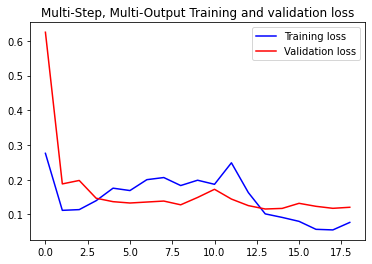

In [19]:
plot_train_history(history, 'Multi-Step, Multi-Output Training and validation loss')

In [20]:
def create_time_steps(length):
    return list(range(-length, 0))

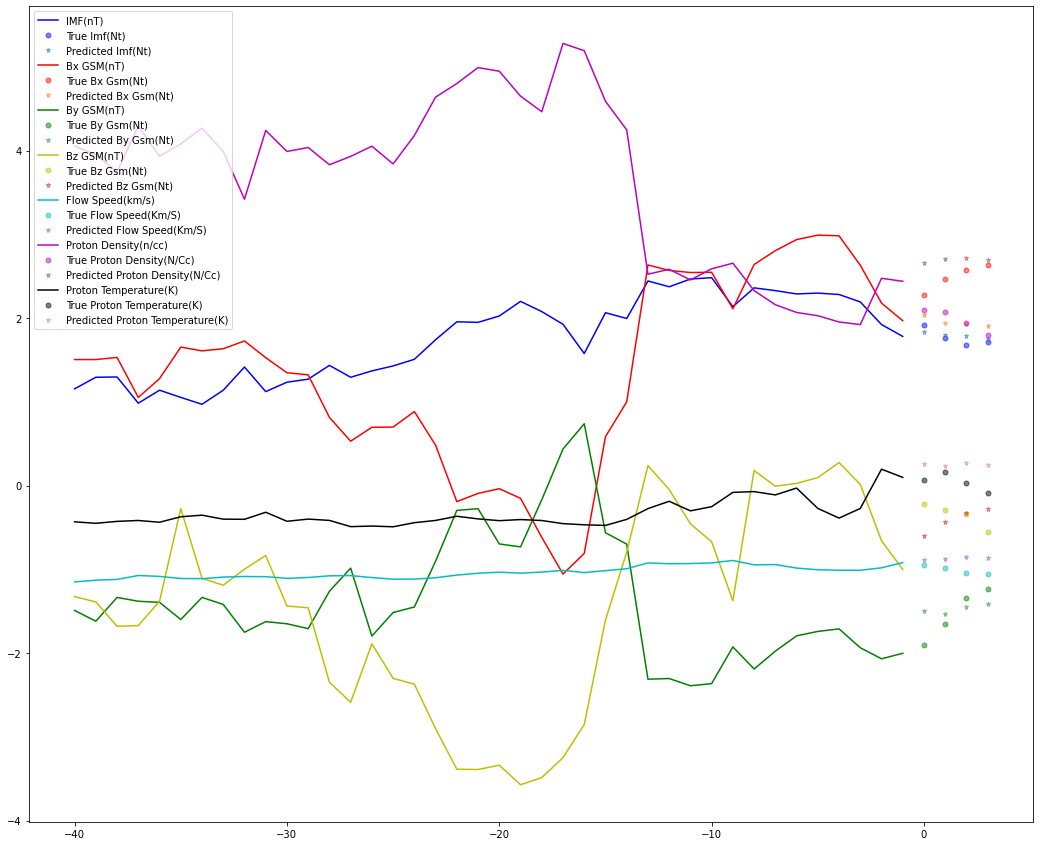

In [21]:
for x, y in val_data_multi.take(1):
    multi_step_output_plot(np.squeeze(x[0]), np.squeeze(y[0]), np.squeeze(model.predict(x[0][np.newaxis,:,:,:,:])))

In [17]:
val_data_multi.take(1)

<TakeDataset shapes: ((None, 40, 7, 1, 1), (None, 4, 7, 1, 1)), types: (tf.float64, tf.float64)>

In [20]:
columnas = df.columns
columnas[2:4]

Index(['By GSM(nT)', 'Bz GSM(nT)', 'Flow Speed(km/s)', 'Proton Density(n/cc)',
       'Proton Temperature(K)'],
      dtype='object')

In [22]:
def multi_step_output_plot(history, true_future, prediction, columnas):
    plt.figure(figsize=(18, 15))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)
    
    #for i, (var, c) in enumerate(zip(features.columns[:2], ['b','r'])):
    #for i, (var, c) in enumerate(zip(df.columns, ['b','r','g','y','c','m','k'])):
    for i, (var, c) in enumerate(zip(columnas, ['b','r','g','y','c','m','k'])):
        plt.plot(num_in, np.array(history[:, i]), c, label=var)
        plt.plot(np.arange(num_out)/STEP, np.array(true_future[:,i]), c+'o', markersize=5, alpha=0.5,
               label=f"True {var.title()}")
        if prediction.any():
            plt.plot(np.arange(num_out)/STEP, np.array(prediction[:,i]), '*', markersize=5, alpha=0.5,
                     label=f"Predicted {var.title()}")
    
    plt.legend(loc='upper left')
    plt.show()

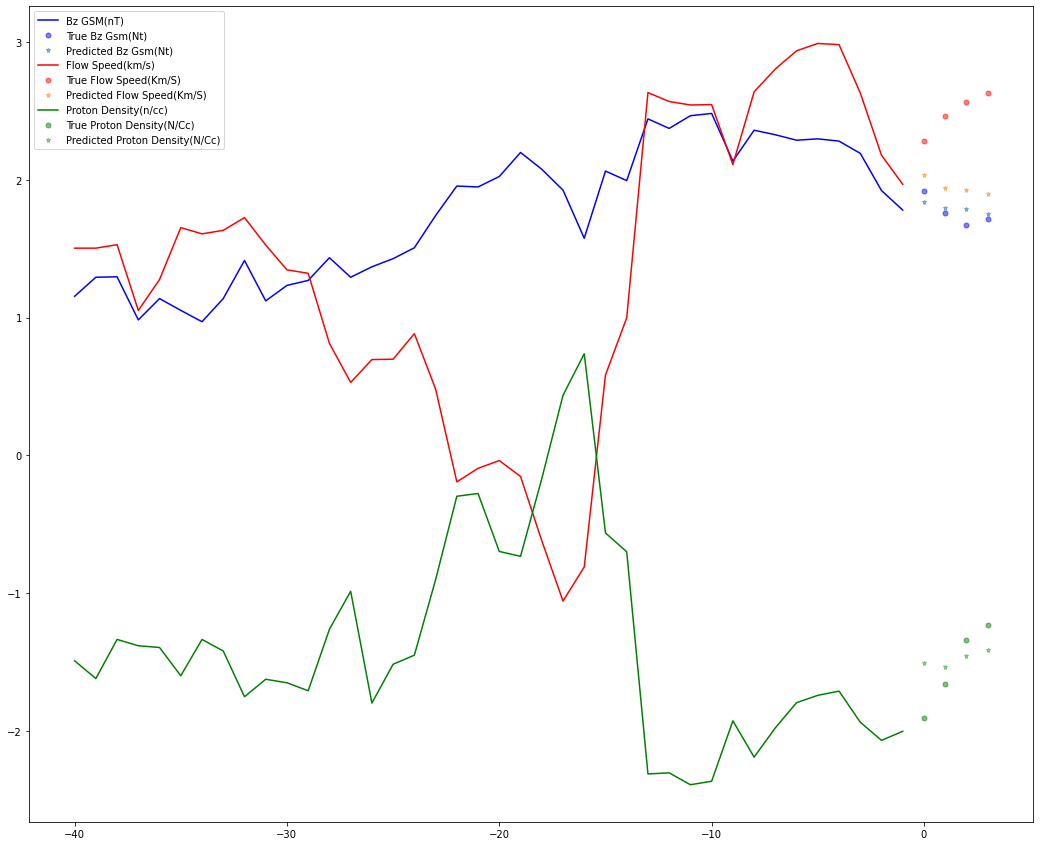

In [33]:
for x, y in val_data_multi.take(1):
    multi_step_output_plot(np.squeeze(x[0]), np.squeeze(y[0]), np.squeeze(model.predict(x[0][np.newaxis,:,:,:,:])),
                           columnas[3:6])

In [35]:
# Generate generalization metrics
score = model.evaluate(x_val_multi, y_val_multi, verbose=1)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

17182/17182 [==============================] - 646s 38ms/step - loss: 0.0853 - mae: 0.1594 - mse: 0.0853
Test loss: 0.08527535945177078 / Test accuracy: 0.15936119854450226


In [135]:
predicciones = model.predict(x_val_multi, verbose=1)

17182/17182 [==============================] - 631s 37ms/step


In [141]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
def obtener_metricas(y_val, y_pred):
    #Aplanamos los datos para que se puedan calcular las metricas
    y_val = np.squeeze(y_val)
    y_val = y_val.ravel()
    y_pred = np.squeeze(y_pred)
    y_pred = y_pred.ravel()
    #Calculamos las metricas
    r2A = r2_score(y_val, y_pred)
    mseA = mean_squared_error(y_val, y_pred)
    maeA = mean_absolute_error(y_val, y_pred)
    rmseA = mseA**0.5
    #Mostramos los resultados en forma de df
    nombres_metricas = ['R2', 'RMSE', 'MSE', 'MAE']
    valores = [r2A, rmseA, mseA, maeA]
    metricas = {'Metrica':nombres_metricas,
                'Valor':valores}
    metricas = pd.DataFrame(metricas)
    return metricas

#obtener_metricas(y_val_multi, predicciones)

In [95]:
#4 timesteps con las 7 variables
predicciones[0][0]

array([[[ 1.8384922 ]],

       [[ 2.0389917 ]],

       [[-1.5034466 ]],

       [[-0.60295975]],

       [[-0.89235234]],

       [[ 2.656132  ]],

       [[ 0.2612059 ]]], dtype=float32)

In [23]:
#Primer time-step
predicciones[0][0]

array([[[ 1.8384922 ]],

       [[ 2.0389917 ]],

       [[-1.5034466 ]],

       [[-0.60295975]],

       [[-0.89235234]],

       [[ 2.656132  ]],

       [[ 0.2612059 ]]], dtype=float32)

In [24]:
#Primera variable del primer timestep de la primera prediccion
predicciones[0][0][0]

array([[1.8384922]], dtype=float32)

In [30]:
predicciones.shape

(549806, 4, 7, 1, 1)

In [33]:
y_val_multi.shape

(549806, 4, 7, 1, 1)

In [136]:
#Devuelve una lista por cada timestep, primera lista = conjunto de primeras predicciones, segunda lista = ... de segundas pred..
def desglose_por_timestep(y_val, predicciones):
    #predicciones.shape[0] = numero de predicciones
    #predicciones.shape[1] = numero de timesteps por prediccion
    #predicciones.shape[2] = numero de variables por timestep
    num_predicciones = predicciones.shape[0]
    num_timesteps   = predicciones.shape[1]
    #num_variables   = predicciones.shape[2]
    #DOS BUCLES, UNO POR LISTA
    timesteps_y_val  = []
    timesteps_y_pred = []
    
    #Creamos 4 listas, una para cada timestep
    for lista_timestep in range(num_timesteps):
        timestep_valN = []
        timesteps_y_val.append(timestep_valN)
        timestep_predN = []
        timesteps_y_pred.append(timestep_predN)
    #Metemos en cada una de los 4 listas, el correspondiente timestep de cada prediccion
    for prediccion in range(num_predicciones):
        for timestep in range(num_timesteps):
            timesteps_y_pred[timestep].append(predicciones[prediccion][timestep])
            timesteps_y_val[timestep].append(y_val[prediccion][timestep])
    
    return timesteps_y_val, timesteps_y_pred

In [94]:
lst_out = []
for i in range(4):
    lst_in = []
    lst_out.append(lst_in)
print(lst_out)

for prediccion in range(10):
    for paso in range(4):
        lst_out[paso].append(paso)

print(lst_out)

[[], [], [], []]
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [3, 3, 3, 3, 3, 3, 3, 3, 3, 3]]


In [137]:
timesteps_y_val, timesteps_y_pred = desglose_por_timestep(y_val_multi, predicciones)

In [148]:
#Obtencion de metricas para cada timestep
for timestep in range(4):
    print("=========TIMESTEP: ",timestep,"=========\n",obtener_metricas(timesteps_y_val[timestep], timesteps_y_pred[timestep]))

=========TIMESTEP:  0 =========
   Metrica     Valor
0      R2  0.942039
1    RMSE  0.210318
2     MSE  0.044234
3     MAE  0.113057
=========TIMESTEP:  1 =========
   Metrica     Valor
0      R2  0.899341
1    RMSE  0.277161
2     MSE  0.076818
3     MAE  0.151824
=========TIMESTEP:  2 =========
   Metrica     Valor
0      R2  0.868362
1    RMSE  0.316953
2     MSE  0.100459
3     MAE  0.176889
=========TIMESTEP:  3 =========
   Metrica     Valor
0      R2  0.843293
1    RMSE  0.345818
2     MSE  0.119590
3     MAE  0.195672


In [149]:
obtener_metricas(y_val_multi, predicciones)

,Metrica,Valor
0,R2,0.888259
1,RMSE,0.292019
2,MSE,0.085275
3,MAE,0.159360


In [162]:
def agrupar_variables_timestep(y_val, y_pred):
    num_predicciones = predicciones.shape[0]
    num_timesteps    = predicciones.shape[1]
    num_variables    = predicciones.shape[2]
    #Creacion de listas
    desglose_val  = []
    desglose_pred = []
    for paso in range(num_timesteps):
        timestepN_val  = []
        timestepN_pred = []
        for i in range(num_variables):
            timestepN_varI_val = []
            timestepN_val.append(timestepN_varI_val)
            
            timestepN_varI_pred = []
            timestepN_pred.append(timestepN_varI_pred)
            
        desglose_val.append(timestepN_val)
        desglose_pred.append(timestepN_pred)
    
    #Desglose
    for prediccion in range(num_predicciones):
        for paso in range(num_timesteps):
            for var in range(num_variables):
                desglose_val[paso][var].append(y_val[prediccion][paso][var])
                desglose_pred[paso][var].append(y_pred[prediccion][paso][var])
    
    return desglose_val, desglose_pred

In [163]:
desglose_val, desglose_pred = agrupar_variables_timestep(y_val_multi, predicciones)

In [161]:
len(desglose_pred), len(desglose_pred[0]), len(desglose_pred[0][0])

(4, 7, 549806)

In [165]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [166]:
nombre_var = df.columns
for paso in range(4):
    print("===================TIMESTEP ", paso,"===================")
    for variable in range(7):
        print("=====VARIABLE", nombre_var[variable],"====")
        print(obtener_metricas(desglose_val[paso][variable], desglose_pred[paso][variable]))

===================TIMESTEP  0 ===================
=====VARIABLE IMF(nT) ====
  Metrica     Valor
0      R2  0.974475
1    RMSE  0.124837
2     MSE  0.015584
3     MAE  0.076259
=====VARIABLE Bx GSM(nT) ====
  Metrica     Valor
0      R2  0.934195
1    RMSE  0.227805
2     MSE  0.051895
3     MAE  0.138729
=====VARIABLE By GSM(nT) ====
  Metrica     Valor
0      R2  0.916962
1    RMSE  0.242632
2     MSE  0.058870
3     MAE  0.146381
=====VARIABLE Bz GSM(nT) ====
  Metrica     Valor
0      R2  0.838639
1    RMSE  0.327873
2     MSE  0.107501
3     MAE  0.193728
=====VARIABLE Flow Speed(km/s) ====
  Metrica     Valor
0      R2  0.989351
1    RMSE  0.096793
2     MSE  0.009369
3     MAE  0.062404
=====VARIABLE Proton Density(n/cc) ====
  Metrica     Valor
0      R2  0.973758
1    RMSE  0.153757
2     MSE  0.023641
3     MAE  0.076933
=====VARIABLE Proton Temperature(K) ====
  Metrica     Valor
0      R2  0.941951
1    RMSE  0.206819
2     MSE  0.042774
3     MAE  0.096967
===============